In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ttim import *

### Use observation times from Oude Korendijk

In [2]:
drawdown = np.loadtxt('data/oudekorendijk_h30.dat')
tobs = drawdown[:,0] / 60 / 24
robs = 30
Q = 788

### Generate data

In [3]:
ml = ModelMaq(kaq=60, z=(-18, -25), Saq=1e-4, tmin=1e-5, tmax=1)
w = Well(ml, xw=0, yw=0, rw=0.1, tsandQ=[(0, 788)], layers=0)
ml.solve()
hobs = ml.head(robs, 0, tobs)[0]

self.neq  1
solution complete


### See if TTim can find aquifer parameters back
Note that the value of Saq0 is printed incorrectly to the screen in the fit report (`lmfit` will fix this hopefully in the near future - issue has be posted). The correct fitted value is printed below the fit report. 

In [4]:
cal = Calibrate(ml)
cal.parameter(name='kaq0', initial=10)
cal.parameter(name='Saq0', initial=1e-4)
cal.series(name='obs1', x=robs, y=0, layer=0, t=tobs, h=hobs)
cal.fit(report=False)
print()
for p in ['kaq0', 'Saq0']:
    print(cal.fitresult.params[p])

............................
<Parameter 'kaq0', value=59.999995924224535 +/- 5.73e-05, bounds=[-inf:inf]>
<Parameter 'Saq0', value=9.999972743010757e-05 +/- 3.21e-10, bounds=[-inf:inf]>


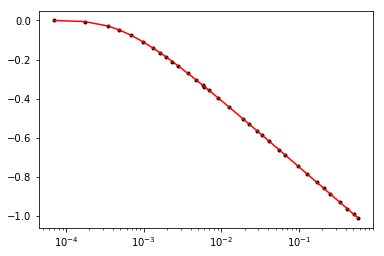

In [5]:
hm = ml.head(robs, 0, tobs, 0)
plt.semilogx(tobs, hobs, '.k')
plt.semilogx(tobs, hm[0], 'r')

### Test whether `lmfit` has fixed the `fit_report` function

In [8]:
from lmfit import Parameters, minimize, fit_report
import numpy as np
p = Parameters()
p.add('a', value=1e-3)
p.add('b', value=10)
ydata = 50 + 1e-4 * np.arange(1, 4) * np.array([1.000001, 0.999999, 0.999998])

def func(p):
    vals = p.valuesdict()  # store dictionary in variable vals
    a = vals['a']
    b = vals['b']
    rv = a * np.arange(1, 4) + b
    return rv - ydata

result = minimize(func, p)
print(fit_report(result))
print('optimal params:')
for p in ['a', 'b']:
    print(result.params[p])

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 3
    # variables        = 2
    chi-square         = 0.00000
    reduced chi-square = 0.00000
    Akaike info crit   = -136.90607
    Bayesian info crit = -138.70885
[[Variables]]
    a:   9.99996740 +/- 7.75e-11 (0.00%) (init= 0.001)
    b:   50         +/- 1.67e-10 (0.00%) (init= 10)
[[Correlations]] (unreported correlations are <  0.100)
    C(a, b)                      = -0.926
optimal params:
<Parameter 'a', value=9.999967403714958e-05 +/- 7.75e-11, bounds=[-inf:inf]>
<Parameter 'b', value=50.00000000036331 +/- 1.67e-10, bounds=[-inf:inf]>
